In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py import ppi_mean_ci, classical_mean_ci
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import _zconfint_generic, _zstat_generic

In [2]:
# Map product points from USDA NASS CDL: https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL
data = pd.read_csv('data/iowa_crop_labels_100k.csv')

In [3]:
data["Ground Truth Corn 2022"] = data['cropland'].apply(lambda x: 1 if x==1 else 0)

In [4]:
Y_total = np.array(data["Ground Truth Corn 2022"])

# True mean (computed on all labels)
true_theta = Y_total.mean()
print(true_theta)

0.35155


In [5]:
# Stratified mean estimation confidence interval

def stratified_mean_ci(strata_to_weights, Y, Y_strata, alpha, alternative="two-sided"):
    mean = 0
    squared_se = 0
    for stratum, weight in strata_to_weights.items():
        Y_stratum = Y[Y_strata==stratum]
        n = Y_stratum.shape[0]
        mean += weight*Y_stratum.mean()
        squared_se += (weight**2)*Y_stratum.var()/n
    return _zconfint_generic(
        mean, np.sqrt(squared_se), alpha, alternative
    )

In [6]:
def run_ppi(Y_total, Yhat_total, ns, num_trials, alpha):     
    results = []
    n_total = Y_total.shape[0]
    strata_to_weights = {0:1-Yhat_total.mean(), 1:Yhat_total.mean()}
    
    for i in tqdm(range(ns.shape[0])):
        for j in range(num_trials):
            # Prediction-Powered Inference
            n = ns[i]
            rand_idx = np.random.RandomState(seed=j).permutation(n_total)
            _Yhat = Yhat_total[rand_idx[:n]]
            _Y = Y_total[rand_idx[:n]]
            _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

            ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)

            # Classical interval
            classical_ci = classical_mean_ci(_Y, alpha=alpha)
            
            # Olofsson interval (equivalent to stratified where Yhat are the strata labels)
            olofsson_ci = stratified_mean_ci(strata_to_weights, _Y, _Yhat, alpha=alpha)

            # Append results
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "PPI",
                            "n": n,
                            "lower": ppi_ci[0],
                            "upper": ppi_ci[1],
                            "trial": j,
                        }
                    ]
                )
            ]
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "Classical",
                            "n": n,
                            "lower": classical_ci[0],
                            "upper": classical_ci[1],
                            "trial": j,
                        }
                    ]
                )
            ]
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "Olofsson",
                            "n": n,
                            "lower": olofsson_ci[0],
                            "upper": olofsson_ci[1],
                            "trial": j,
                        }
                    ]
                )
            ]

    # Imputed CI
    imputed_ci = classical_mean_ci(Yhat_total, alpha=alpha)
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Imputation",
                    "n": np.nan,
                    "lower": imputed_ci[0],
                    "upper": imputed_ci[1],
                    "trial": 0,
                }
            ]
        )
    ]

    df = pd.concat(results, axis=0, ignore_index=True)
    df["width"] = df["upper"] - df["lower"]
    df["estimate"] = 0.5*(df["upper"] + df["lower"])
    return df

# Experiments: Adding Noise

In [7]:
# Add noise to ML model (resample with probability p, from Bernoulli(true_theta) distribution)
probabilities = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
model_accuracies = []
ppi_avg_estimates = []
ppi_avg_widths = []
olofsson_avg_estimates = []
olofsson_avg_widths = []
imputation_estimates = []
imputation_widths = []

for p in probabilities:
    noise_mask = np.array(np.random.RandomState(seed=42).choice([0,1], p=[1-p, p], size = Y_total.shape[0]))
    random_labels = np.array(np.random.RandomState(seed=int(10*p)).choice([0, 1], p=[1-true_theta, true_theta], size=Y_total.shape[0]))
    noisy_Yhat_total = Y_total*(1-noise_mask) + random_labels*noise_mask
    model_accuracy = (Y_total==noisy_Yhat_total).sum() / Y_total.size
    model_accuracies.append(model_accuracy)

    df = run_ppi(Y_total, noisy_Yhat_total, ns=np.array([100]), num_trials=100, alpha=0.05)

    ppi_results = df.loc[(df['method'] == 'PPI') & (df['n'] == 100)]
    ppi_avg_estimates.append(ppi_results['estimate'].mean())
    ppi_avg_widths.append(ppi_results['width'].mean())
    
    olofsson_results = df.loc[(df['method'] == 'Olofsson') & (df['n'] == 100)]
    olofsson_avg_estimates.append(olofsson_results['estimate'].mean())
    olofsson_avg_widths.append(olofsson_results['width'].mean())
    
    classical_results = df.loc[(df['method'] == 'Classical') & (df['n'] == 100)]
    classical_avg_estimate = classical_results['estimate'].mean()
    classical_avg_width = classical_results['width'].mean()
    
    imputation_estimates.append(df.loc[df['method']=='Imputation']['estimate'].mean())
    imputation_widths.append(df.loc[df['method']=='Imputation']['width'].mean())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


In [8]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=10)          
plt.rc('axes', titlesize=22)     
plt.rc('axes', labelsize=18)    
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14)    
plt.rc('legend', fontsize=13)    
plt.rc('figure', titlesize=22)

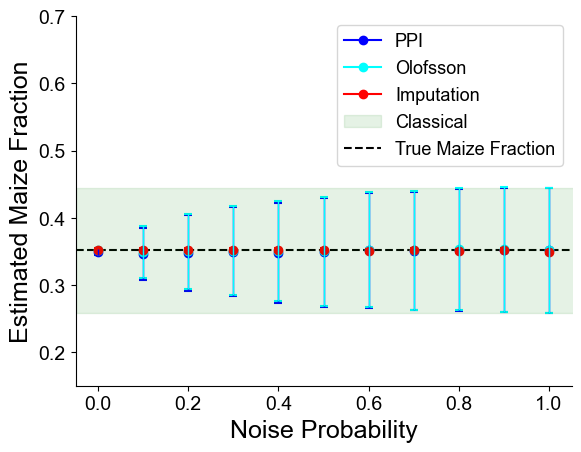

In [9]:
# Visualize estimated maize fraction at different noise levels
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot([], '-o', color='blue', label='PPI')
plt.plot([], '-o', color='cyan', label='Olofsson')
plt.plot([], '-o', color='red', label='Imputation')

plt.scatter(probabilities, ppi_avg_estimates, color='blue')
plt.scatter(probabilities, ppi_avg_estimates-np.array(ppi_avg_widths)/2, color='blue', marker='_')
plt.scatter(probabilities, ppi_avg_estimates+np.array(ppi_avg_widths)/2, color='blue', marker='_')
for i, prob in enumerate(probabilities):
    ymin = (ppi_avg_estimates-np.array(ppi_avg_widths)/2)[i]
    ymax = (ppi_avg_estimates+np.array(ppi_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="blue", linewidth=1)
    
plt.scatter(probabilities, olofsson_avg_estimates, color='cyan')
plt.scatter(probabilities, olofsson_avg_estimates-np.array(olofsson_avg_widths)/2, color='cyan', marker='_')
plt.scatter(probabilities, olofsson_avg_estimates+np.array(olofsson_avg_widths)/2, color='cyan', marker='_')
for i, prob in enumerate(probabilities):
    ymin = (olofsson_avg_estimates-np.array(olofsson_avg_widths)/2)[i]
    ymax = (olofsson_avg_estimates+np.array(olofsson_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="cyan", linewidth=1)

plt.scatter(probabilities, imputation_estimates, color='red')
plt.scatter(probabilities, imputation_estimates-np.array(imputation_widths)/2, color='red', marker='_')
plt.scatter(probabilities, imputation_estimates+np.array(imputation_widths)/2, color='red', marker='_')


plt.fill_between(np.arange(-0.05, 1.2, 0.1), classical_avg_estimate-classical_avg_width/2, classical_avg_estimate+classical_avg_width/2, color='green', alpha=0.1, label='Classical')

plt.axhline(true_theta, color ='black', linestyle='--', label='True Maize Fraction', zorder=0)

plt.legend()
plt.xlim([-0.05, 1.05])
plt.ylim([0.15, 0.7])
#plt.title("Corn Fraction Confidence Intervals")
plt.ylabel("Estimated Maize Fraction")
plt.xlabel("Noise Probability")
plt.savefig('output_images/corn_fraction_noise.png', dpi=300, bbox_inches='tight')
plt.show()

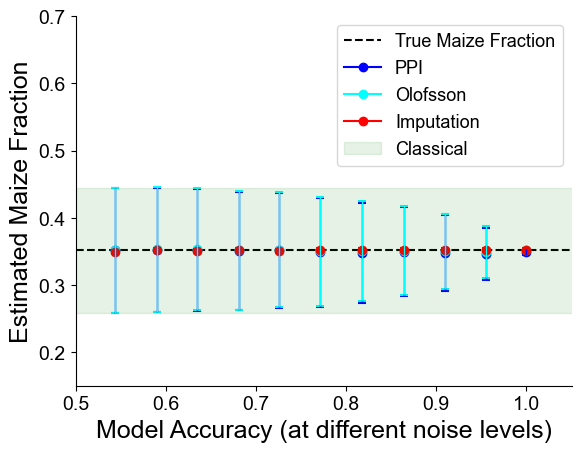

In [10]:
# Visualize estimated maize fraction at different model accuracies (from varying noise level)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axhline(true_theta, color ='black', linestyle='--', label='True Maize Fraction', zorder=0)

plt.plot([], '-o', color='blue', label='PPI')
plt.plot([], '-o', color='cyan', label='Olofsson')
plt.plot([], '-o', color='red', label='Imputation')

plt.scatter(model_accuracies, ppi_avg_estimates, color='blue')
plt.scatter(model_accuracies, ppi_avg_estimates-np.array(ppi_avg_widths)/2, color='blue', marker='_')
plt.scatter(model_accuracies, ppi_avg_estimates+np.array(ppi_avg_widths)/2, color='blue', marker='_')
for i, prob in enumerate(model_accuracies):
    ymin = (ppi_avg_estimates-np.array(ppi_avg_widths)/2)[i]
    ymax = (ppi_avg_estimates+np.array(ppi_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="blue", linewidth=1)
    
plt.scatter(model_accuracies, olofsson_avg_estimates, color='cyan')
plt.scatter(model_accuracies, olofsson_avg_estimates-np.array(olofsson_avg_widths)/2, color='cyan', marker='_')
plt.scatter(model_accuracies, olofsson_avg_estimates+np.array(olofsson_avg_widths)/2, color='cyan', marker='_')
for i, prob in enumerate(model_accuracies):
    ymin = (olofsson_avg_estimates-np.array(olofsson_avg_widths)/2)[i]
    ymax = (olofsson_avg_estimates+np.array(olofsson_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="cyan", linewidth=1)

plt.scatter(model_accuracies, imputation_estimates, color='red')
plt.scatter(model_accuracies, imputation_estimates-np.array(imputation_widths)/2, color='red', marker='_')
plt.scatter(model_accuracies, imputation_estimates+np.array(imputation_widths)/2, color='red', marker='_')


plt.fill_between(np.arange(-0.05, 1.2, 0.1), classical_avg_estimate-classical_avg_width/2, classical_avg_estimate+classical_avg_width/2, color='green', alpha=0.1, label='Classical')

plt.legend()
plt.xlim([0.5, 1.05])
plt.ylim([0.15, 0.7])
#plt.title("Corn Fraction Confidence Intervals")
plt.ylabel("Estimated Maize Fraction")
plt.xlabel("Model Accuracy (at different noise levels)")
plt.savefig('output_images/corn_fraction_noise_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Kerri\AppData\Local\Temp\ipykernel_7612\3298974324.py:9: RuntimeWarning: divide by zero encountered in divide
  olofsson_effective_sample_sizes = 100*(classical_avg_width**2)/(np.array(olofsson_avg_widths)**2)


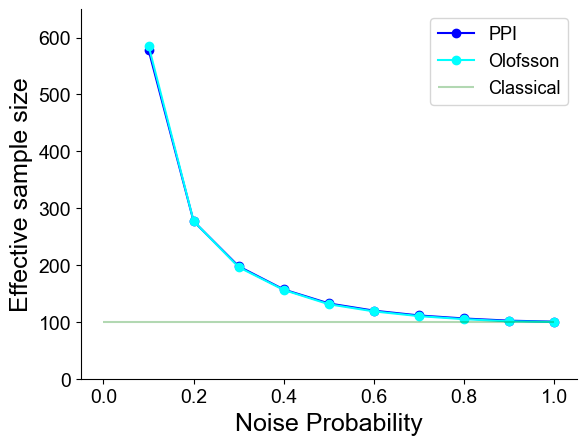

In [11]:
# Visualize effective sample size at different noise levels
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ppi_effective_sample_sizes = 100*(classical_avg_width**2)/(np.array(ppi_avg_widths)**2)
plt.plot(probabilities[1:], ppi_effective_sample_sizes[1:], '-bo', label='PPI')

olofsson_effective_sample_sizes = 100*(classical_avg_width**2)/(np.array(olofsson_avg_widths)**2)
plt.plot(probabilities[1:], olofsson_effective_sample_sizes[1:], '-o', color='cyan', label='Olofsson')

plt.hlines(100, 0, 1, color='green', alpha=0.3, label='Classical')

plt.xlabel("Noise Probability")
plt.ylabel("Effective sample size")
plt.ylim([0, 650])
plt.legend()
plt.savefig('output_images/corn_fraction_noise_effective_sample_size.png', dpi=300, bbox_inches='tight')
plt.show()

# Experiments: Adding Bias

In [12]:
# Add bias to ML model (resample with probability 0.4, from a distribution with probability p of being corn)
probabilities = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
model_accuracies = []
ppi_avg_estimates = []
ppi_avg_widths = []
olofsson_avg_estimates = []
olofsson_avg_widths = []
imputation_estimates = []
imputation_widths = []

for p in probabilities:
    bias_mask = np.array(np.random.RandomState(seed=int(10*p)).choice([0,1], p=[0.6, 0.4], size = Y_total.shape[0]))
    random_labels = np.array(np.random.RandomState(seed=42).choice([0, 1], p=[1-p, p], size=Y_total.shape[0]))
    biased_Yhat_total = Y_total*(1-bias_mask) + random_labels*bias_mask
    model_accuracy = (Y_total==biased_Yhat_total).sum() / Y_total.size
    model_accuracies.append(model_accuracy)

    df = run_ppi(Y_total, biased_Yhat_total, ns=np.array([100]), num_trials=100, alpha=0.05)
    
    ppi_results = df.loc[(df['method'] == 'PPI') & (df['n'] == 100)]
    ppi_avg_estimates.append(ppi_results['estimate'].mean())
    ppi_avg_widths.append(ppi_results['width'].mean())
    
    classical_results = df.loc[(df['method'] == 'Classical') & (df['n'] == 100)]
    classical_avg_estimate = classical_results['estimate'].mean()
    classical_avg_width = classical_results['width'].mean()
    
    olofsson_results = df.loc[(df['method'] == 'Olofsson') & (df['n'] == 100)]
    olofsson_avg_estimates.append(olofsson_results['estimate'].mean())
    olofsson_avg_widths.append(olofsson_results['width'].mean())
    
    imputation_estimates.append(df.loc[df['method']=='Imputation']['estimate'].mean())
    imputation_widths.append(df.loc[df['method']=='Imputation']['width'].mean())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.04it/s]


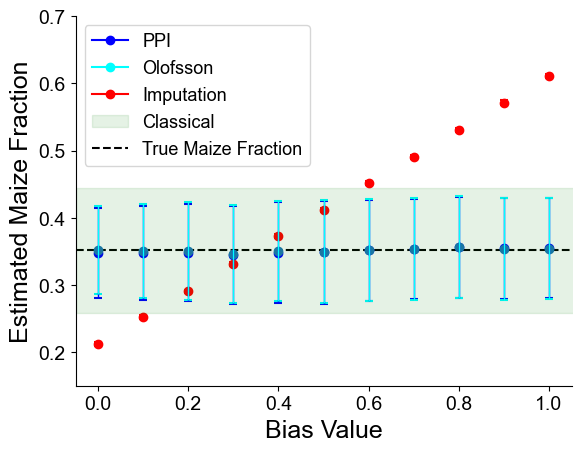

In [13]:
# Visualize estimated maize fraction at different bias levels
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot([], '-o', color='blue', label='PPI')
plt.plot([], '-o', color='cyan', label='Olofsson')
plt.plot([], '-o', color='red', label='Imputation')

plt.scatter(probabilities, ppi_avg_estimates, color='blue')
plt.scatter(probabilities, ppi_avg_estimates-np.array(ppi_avg_widths)/2, color='blue', marker='_')
plt.scatter(probabilities, ppi_avg_estimates+np.array(ppi_avg_widths)/2, color='blue', marker='_')
for i, prob in enumerate(probabilities):
    ymin = (ppi_avg_estimates-np.array(ppi_avg_widths)/2)[i]
    ymax = (ppi_avg_estimates+np.array(ppi_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="blue", linewidth=1)
    
plt.scatter(probabilities, olofsson_avg_estimates)
plt.scatter(probabilities, olofsson_avg_estimates-np.array(olofsson_avg_widths)/2, color='cyan', marker='_')
plt.scatter(probabilities, olofsson_avg_estimates+np.array(olofsson_avg_widths)/2, color='cyan', marker='_')
for i, prob in enumerate(probabilities):
    ymin = (olofsson_avg_estimates-np.array(olofsson_avg_widths)/2)[i]
    ymax = (olofsson_avg_estimates+np.array(olofsson_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="cyan", linewidth=1)

plt.scatter(probabilities, imputation_estimates, color='red')
plt.scatter(probabilities, imputation_estimates-np.array(imputation_widths)/2, color='red', marker='_')
plt.scatter(probabilities, imputation_estimates+np.array(imputation_widths)/2, color='red', marker='_')

plt.fill_between(np.arange(-0.05, 1.2, 0.1), classical_avg_estimate-classical_avg_width/2, classical_avg_estimate+classical_avg_width/2, color='green', alpha=0.1, label='Classical')

plt.axhline(true_theta, color ='black', linestyle='--', label='True Maize Fraction', zorder=0)

plt.legend()
plt.xlim([-0.05, 1.05])
plt.ylim([0.15, 0.7])
#plt.title("Corn Fraction Confidence Intervals")
plt.ylabel("Estimated Maize Fraction")
plt.xlabel("Bias Value")
plt.savefig('output_images/corn_fraction_bias.png', dpi=300, bbox_inches='tight')
plt.show()

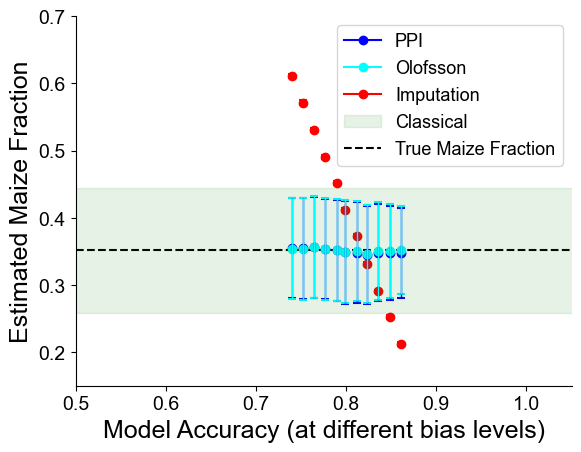

In [14]:
# Visualize estimated maize fraction at different model accuracies (from varying bias levels)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot([], '-o', color='blue', label='PPI')
plt.plot([], '-o', color='cyan', label='Olofsson')
plt.plot([], '-o', color='red', label='Imputation')

plt.scatter(model_accuracies, ppi_avg_estimates, color='blue')
plt.scatter(model_accuracies, ppi_avg_estimates-np.array(ppi_avg_widths)/2, color='blue', marker='_')
plt.scatter(model_accuracies, ppi_avg_estimates+np.array(ppi_avg_widths)/2, color='blue', marker='_')
for i, prob in enumerate(model_accuracies):
    ymin = (ppi_avg_estimates-np.array(ppi_avg_widths)/2)[i]
    ymax = (ppi_avg_estimates+np.array(ppi_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="blue", linewidth=1)
    
plt.scatter(model_accuracies, olofsson_avg_estimates, color='cyan')
plt.scatter(model_accuracies, olofsson_avg_estimates-np.array(olofsson_avg_widths)/2, color='cyan', marker='_')
plt.scatter(model_accuracies, olofsson_avg_estimates+np.array(olofsson_avg_widths)/2, color='cyan', marker='_')
for i, prob in enumerate(model_accuracies):
    ymin = (olofsson_avg_estimates-np.array(olofsson_avg_widths)/2)[i]
    ymax = (olofsson_avg_estimates+np.array(olofsson_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="cyan", linewidth=1)

plt.scatter(model_accuracies, imputation_estimates, color='red')
plt.scatter(model_accuracies, imputation_estimates-np.array(imputation_widths)/2, color='red', marker='_')
plt.scatter(model_accuracies, imputation_estimates+np.array(imputation_widths)/2, color='red', marker='_')

plt.fill_between(np.arange(-0.05, 1.2, 0.1), classical_avg_estimate-classical_avg_width/2, classical_avg_estimate+classical_avg_width/2, color='green', alpha=0.1, label='Classical')

plt.axhline(true_theta, color ='black', linestyle='--', label='True Maize Fraction', zorder=0)

plt.legend()
plt.xlim([0.5, 1.05])
plt.ylim([0.15, 0.7])
#plt.title("Corn Fraction Confidence Intervals")
plt.ylabel("Estimated Maize Fraction")
plt.xlabel("Model Accuracy (at different bias levels)")
plt.savefig('output_images/corn_fraction_bias_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()